# Cartoon K-means

In this notebook, we show you how to implement an in-built method for k means clustering from sklearn.cluster and apply this to some images to make them stylized and cartoon-ish, so you'll even learn a little bit about images, pixels and colour. In the last section we show you our own k-means algorithm to explain step by step how it works.



# Mount Drive

In [1]:
from google.colab import drive
drive.mount('/gdrive')

rootPath = '/gdrive/My Drive/Accessed Memory/2021 Summer/Cartoon_Kmeans/'   ## This just allows us to access photo's from our Google Drive when using Google Colab.

Mounted at /gdrive


# Import Packages

In [2]:
import numpy as np
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans

# Visualize Colour Space of Image

First we have to import the image.

In [5]:
test_image = Image.open(rootPath + 'Test_Images/parrot.jpeg')     ## This is just the path to your image.

The image has three channels: red, green and blue. Every pixel in each channel has an integer value between 0 and 255, where 0 is less of a colour and 255 is more of that colour. We need to turn these values in to floats (essentially numbers with decimals). Then we need to rescale the image to between 0 and 1 as matplotlib works better with this range. 

In [6]:
test_image = np.array(test_image)
test_image = test_image.astype('float32')
test_image /= 255

Let's look at the test image.

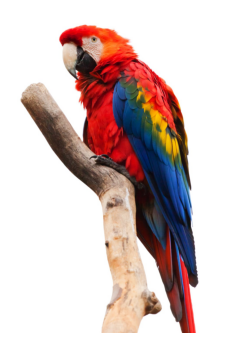

In [7]:
plt.figure(figsize = (6,6))
plt.imshow(test_image)
plt.axis('off')
plt.show()

There are a lot of pixels in this image. To make the calculations we want to make it wouldn't take long but visualizing the whole image in a colour space to explain what k-means clustering does, takes up a lot of RAM and takes a long time to plot. So for visualisation purposes, lets downsample the image by a factor of 8.

In [8]:
test_down = np.array([test_image[0::8,0::8, 0], ## This notation just means to take every 8th value that specific dimension in the array.
                      test_image[0::8,0::8, 1],
                      test_image[0::8,0::8, 2]]) ## The output is (3,w,h) so we need to reshape it.
test_down = test_down.transpose(1,2,0)

Let's look at the output. It's going to look a bit pixelated.

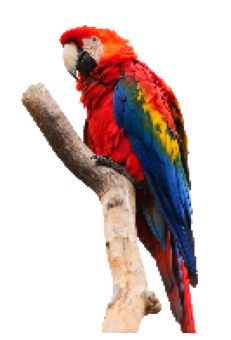

In [9]:
plt.figure(figsize = (6,6))
plt.imshow(test_down)
plt.axis('off')
plt.show()

So let's take a look at every pixel in this image and plot it on a 3 dimensional axis. Each dimension is red, green and blue. The coordinate is also the colour of the pixel. This cell takes ~ 55 seconds to produce the plot and 50 seconds to actually display it.

100%|██████████| 188/188 [00:55<00:00,  3.38it/s]


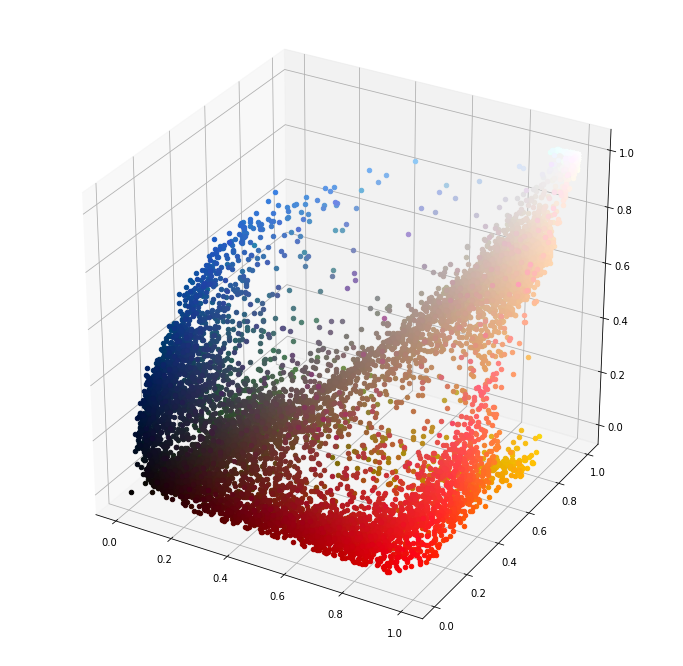

In [ ]:
fig = plt.figure(figsize = (12,12))
ax = fig.add_subplot(projection='3d')
for i in tqdm(range(test_down.shape[0])):
  for j in range(test_down.shape[1]):
    ax.scatter(test_down[i][j][0],
               test_down[i][j][1],
               test_down[i][j][2],
               color = (test_down[i][j][0],
                        test_down[i][j][1],
                        test_down[i][j][2]))
plt.show()

We can already see that colours are generally forming clusters in this 3D space.  There appears to be a lot of black, red, white, blue and beige/tan/whatever you want to call it.

How kmeans clustering works is that it takes our data, and plops k points amongst our data (we specify k which is the number of clusters). K means is unsupervised so once we specify how many clusters we want, it gets to work. It calculates the distance between our randomly placed cluster centers and each data point. Each of these data points will be closer to one cluster center than the rest, so this data point belongs to that cluster center. Once all of the data points have been assigned to a cluster, the mean of these points is calculated and these are the new coordinates of the cluster centers. This repeats until the cluster centers don't move any more. That is it.

To prepare our data for k-means clustering we need our data to be in a cordinate format. At the moment our image is (w,h,3) but we need it as (w*h, 3) so that each pixel is in the form [r, g, b] and our image contains a list of these.

In [10]:
coords = [[test_down[i][j][0], test_down[i][j][1], test_down[i][j][2]] for i in range(test_down.shape[0]) for j in range(test_down.shape[1])]

Our coordinates are currently a list of lists so lets change it to a np array so it's easier to work with.

In [11]:
coords = np.array(coords)

Now lets apply k-means to our pixels!

I have specified 5 clusters to see how well my guesses were for the colours I stated earlier.

In [75]:
kmeans = KMeans(n_clusters = 5, random_state = 420).fit(coords)

Lets define a seperate variable for the coordinates for the centers of the clusters.

In [76]:
centers = kmeans.cluster_centers_

Now lets compare our pixel data with the cluster centers. Here the pixel coordinates are plotted and not the colours so it is faster to plot (~ 1.5s).

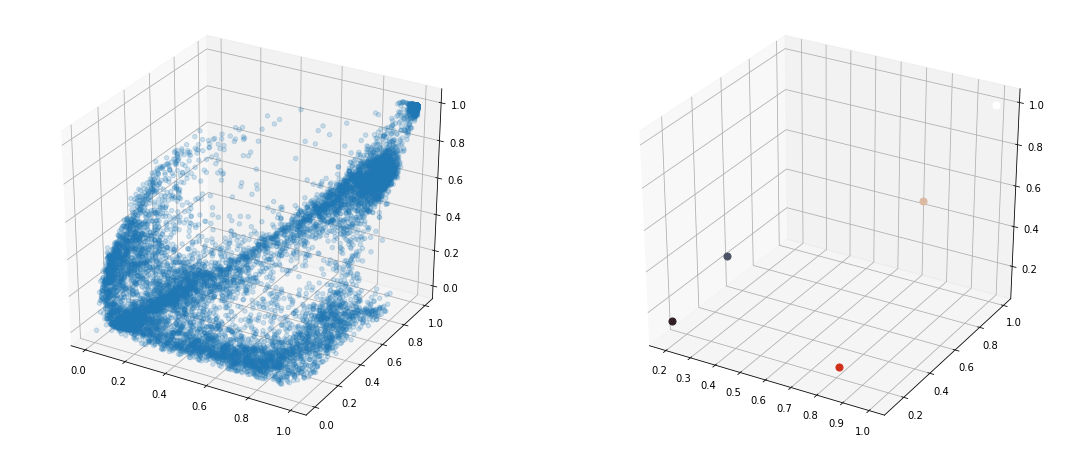

In [77]:
fig = plt.figure(figsize = (19,8))
ax = fig.add_subplot(1,2,1, projection='3d')                        ## The (1,2,1) says the number of rows, number of columns and the position within these starting from left to right, top to bottom. 
ax.scatter(coords[:,0], coords[:,1], coords[:,2], alpha = 0.2)

ax = fig.add_subplot(1,2,2, projection='3d')
for i in range(len(centers)):
  ax.scatter(centers[i,0], centers[i,1], centers[i,2], s = 50, 
             color = (centers[i,0], centers[i,1], centers[i,2]))
plt.show()

To get these values back into integer RGB values, just perform `np.round(255*centers)`.

In [78]:
np.round(255*centers)

array([[255., 255., 255.],
       [ 76.,  83., 100.],
       [208.,  48.,  26.],
       [ 49.,  31.,  36.],
       [219., 186., 162.]], dtype=float32)

Well the guesses of black white and red were correct but I wasn't predicting beige or like a dark blue. 

Let's feed our pixels back into the model to see which clusters they belong to, and recreate the image by assigning the cluster colour to each pixel and then view it!

In [79]:
test_fitted = kmeans.predict(coords)

The coordinate list is copied and for each pixel we are rreplacing it with it's corresponding cluster colour that it is closest to.

In [80]:
coords_copy = coords.copy()
for i in range(len(test_fitted)):
  center = centers[test_fitted[i]]
  coords_copy[i] = center

Our output is (w*h, 3) and we need it back in the form of (w,h,3) so let's do that.

In [81]:
test_means = coords_copy.reshape(test_down.shape)

Make sure it's all good.

In [82]:
test_means.shape

(188, 125, 3)

Now view our output!

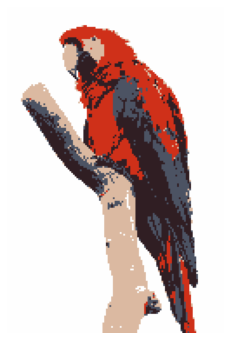

In [83]:
plt.figure(figsize = (6,6))
plt.imshow(test_means)
plt.axis('off')
plt.show()

Looks pretty dope tbh. Let's create a method that can do it all at once with a specified number of clusters and downsampling amount. 

We can take these clusters and put other images through it so that we roduce that image but with this set of clusters.

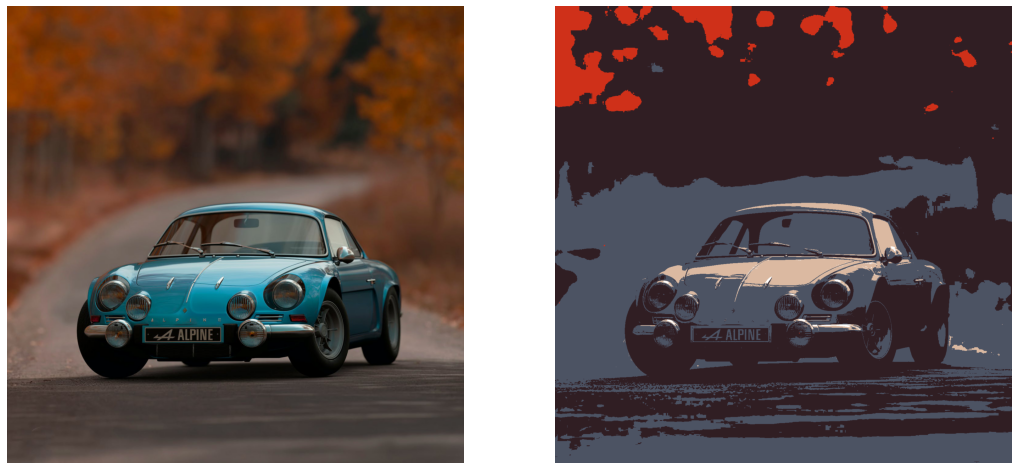

In [86]:
test_image2 = Image.open(rootPath + 'Test_Images/car.jpeg')
test_image2 = np.array(test_image2)
test_image2 = test_image2.astype('float32')
test_image2 /= 255

coord2 = [[test_image2[i][j][0], 
           test_image2[i][j][1], 
           test_image2[i][j][2]] for i in range(test_image2.shape[0]) for j in range(test_image2.shape[1])]
coord2 = np.array(coord2)

test_fitted2 = kmeans.predict(coord2)

coords_copy2 = coord2.copy()
for i in range(len(test_fitted2)):
  coords_copy2[i] = centers[test_fitted2[i]]

test_means2 = coords_copy2.reshape(test_image2.shape)

plt.figure(figsize = (18, 9))
plt.subplot(1,2,1)
plt.imshow(test_image2)
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(test_means2)
plt.axis('off')
plt.show()

Once again... pretty dope.

# The Function

In [4]:
def cartoonify_image( image_path , k , downsample ):
  image = Image.open(image_path)
  image = np.array(image)
  image = image.astype('float32')
  image /= 255

  image_down = np.array([image[0::downsample, 0::downsample, 0],
                         image[0::downsample, 0::downsample, 1],
                         image[0::downsample, 0::downsample, 2]]) 
  image_down = image_down.transpose(1,2,0)

  coords = [[image_down[i][j][0], 
             image_down[i][j][1], 
             image_down[i][j][2]] for i in range(image_down.shape[0]) for j in range(image_down.shape[1])]
  coords = np.array(coords)

  kmeans = KMeans(n_clusters = k).fit(coords)
  centers = kmeans.cluster_centers_

  fitted_coords = kmeans.predict(coords)

  coords_copy = coords.copy()
  for i in range(len(fitted_coords)):
    coords_copy[i] = centers[fitted_coords[i]]
  
  image_means = coords_copy.reshape(image_down.shape)

  plt.figure(figsize = (18, 9))
  plt.subplot(1,2,1)
  plt.imshow(image)
  plt.axis('off')

  plt.subplot(1,2,2)
  plt.imshow(image_means)
  plt.axis('off')
  plt.show()

# Parrot Example

First test on the example resolution. Ran in about 1.6 seconds.

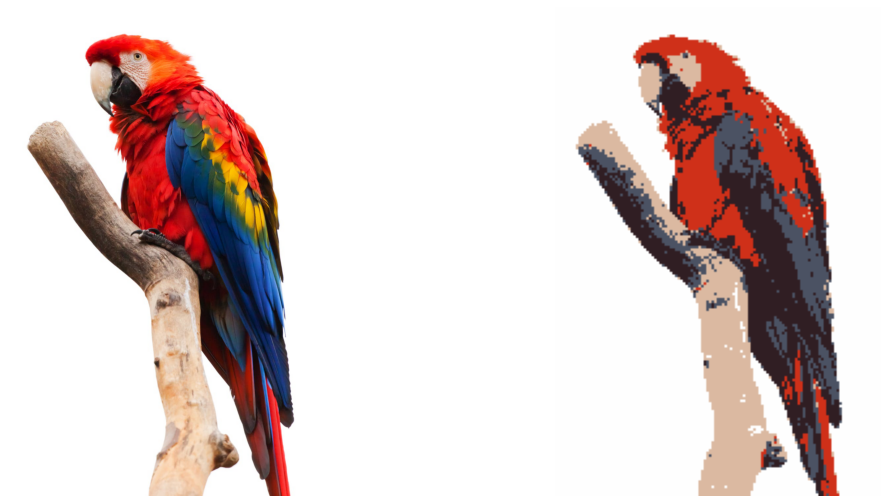

In [ ]:
cartoonify_image(rootPath + 'Test_Images/parrot.jpeg', 5, 8)        ## Run in ~1.6 seconds 

Run on full resolution. Roughly 25s.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


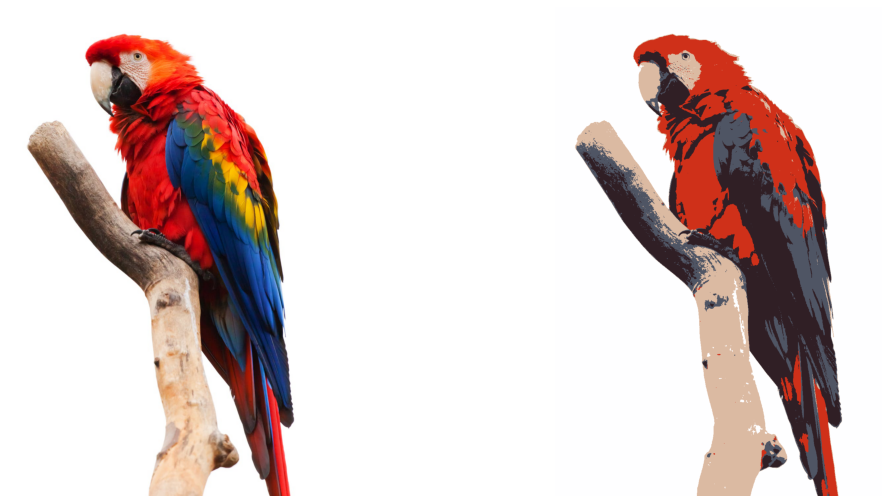

In [ ]:
cartoonify_image(rootPath + 'Test_Images/parrot.jpeg', 5, 1) ## At full resolution ~ 25s

The more clusters you specify, the more colours we get and it starts to resemble the image more.

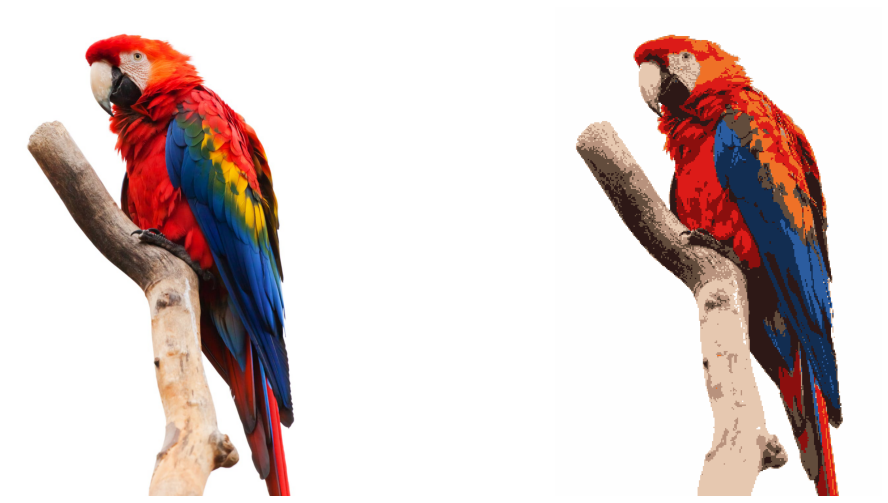

In [ ]:
cartoonify_image(rootPath + 'Test_Images/parrot.jpeg', 10, 4) # The more clusters you specify, the 

# Step By Step

In this section, we will look at the algorithm at each step.
We'll visualise the centers and we'll calculate the average distance moved each time.

In [ ]:
from sklearn.datasets import make_blobs
import pandas as pd

Let's creat three clusters of data points.

In [ ]:
centers = [[1, 1], [-1, -1], [1, -1]]
X, _ = make_blobs(n_samples=10000, centers=centers, cluster_std=0.6)

Let's have a look at our blobs.

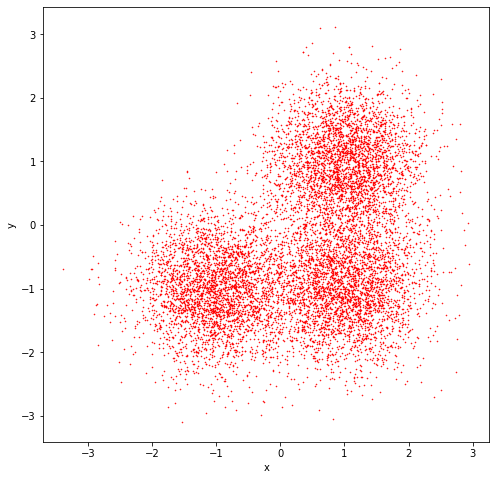

In [ ]:
plt.figure(figsize = (8,8))
plt.scatter(X[:, 0], X[:, 1], c = 'r', s = 0.3)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

Before we do it step by step, let's see what the built in k-means method returns. We have specified 3 clusters, so should be an easy problem if we specify k = 3.

In [ ]:
kmeans = KMeans(n_clusters = 3, max_iter=1).fit(X)

In [ ]:
clusters = kmeans.cluster_centers_

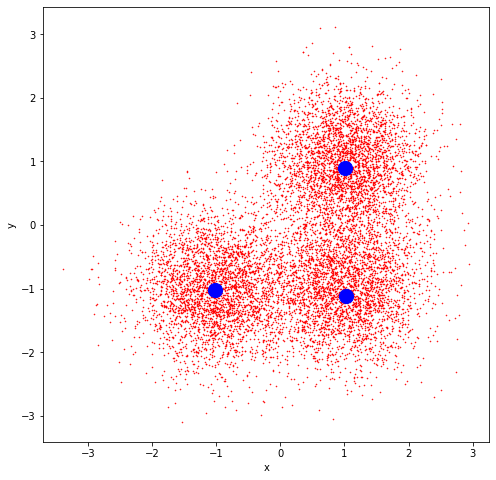

In [ ]:
plt.figure(figsize = (8,8))
plt.scatter(X[:, 0], X[:, 1], c = 'r', s = 0.3)
plt.scatter(clusters[:,0], clusters[:,1], s = 200, c = 'b')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

Yeah, this is as we expected. So now we know whats we're aiming for, lets do it step by step.

First we need a function that can calculate the distance between 2 points on our 2D plane. Just use classic pythagorus $C = \sqrt{(A^2 + B^2)}$  where $A$ and $B$ are the diffences between the x-coordinates and the y-coordinates.

In [ ]:
def distance(coord1, coord2):
  return ((coord1[0] - coord2[0])**2 + (coord1[1] - coord2[1])**2) **0.5

Again, let's create some blobs of point the same as before. Then we select k points at random from all the blobs. These act as the starting positions for our cluster centers (centroids).

In [ ]:
k = 3                                                                           ## Define the number of clusters.
blob_centers = [[1, 1], [-1, -1], [1, -1]]                                      ## Define the coordinates for the blobs to be centered on.
X, _ = make_blobs(n_samples=10000, centers=blob_centers, cluster_std=0.6)       ## Create the blobs with the specified centers.
init_cent_idx = np.random.randint( 0, X.shape[0], k)                            ## Randomly select the indices of k data points to act as initial centroids.
centers = np.asarray([X[i] for i in init_cent_idx])                             ## Retreive the data point that correspond to the indices and keep them in a numpy array for ease.
X = pd.DataFrame(X, columns = ['x', 'y'])                                       ## Convert the blob data into a datafram so it's easy to select rows.

Let's visualise our initial centroids!

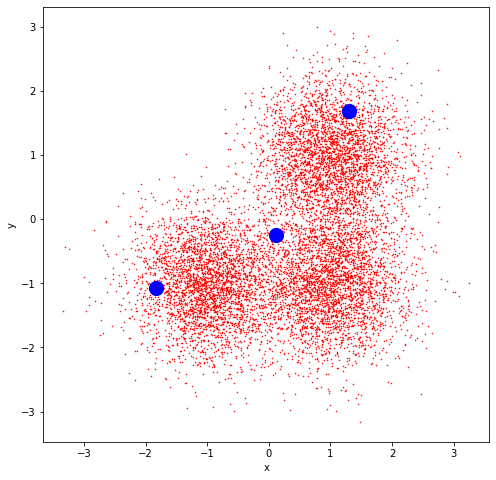

In [ ]:
plt.figure(figsize = (8,8))
plt.scatter(X['x'], X['y'], c = 'r', s = 0.3)
plt.scatter(centers[:,0], centers[:,1], s = 200, c = 'b')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

The next step is to calculate the distance between each data point and the centroids to see which data points lie closest to each centroid and thus belong to that cluster.

In [ ]:
labs = []                                                                       ## Here we collect the labels of the cluster it belongs to e.g. 0, 1, 2, ..., k.
for i in range(len(X)):                                                         ## Iterate through each data point.
  dis = [distance(X.iloc[i], center) for center in centers]                     ## Calculate the distance from each centroid.
  labs.append(dis.index(min(dis)))                                              ## Append the index of the closest centroid.

X['labs'] = labs                                                                ## Add these labels as a column in the blob dataframe

Let's see which data points belong to which cluster.

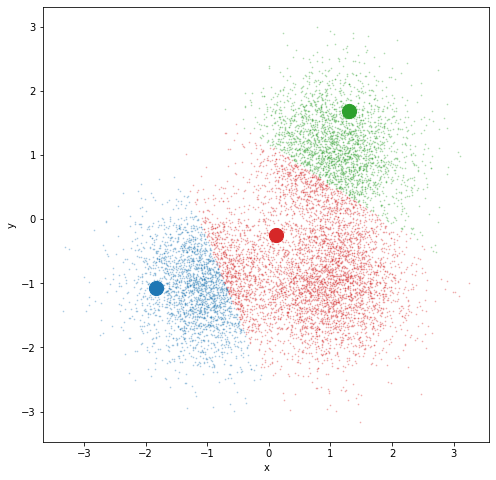

In [ ]:
plt.figure(figsize = (8,8))                                                       ## Initialise the figure/plot.
colours = ['tab:blue', 'tab:red', 'tab:green']                                  ## I defined three colours to use because I specified 3 clusters.
for i in range(centers.shape[0]):                                               ## Iterate through the number of centroids (k).
  temp = X[X['labs'] == i]                                                      ## For each centroid (e.g. 0) select the data points with that label.
  plt.scatter(temp['x'], temp['y'], color = colours[i], alpha = 0.3, s = 0.5)   ## Plot the (x, y) coordinates of the data points with that label with its specific colour. (alpha is opacity).
  plt.scatter(centers[i,0], centers[i,1], s = 200, color = colours[i])          ## Plot the (x,y) coordinates of the centroids with the same colour but a bigger marker size (s).

plt.xlabel('x')                                                                 ## Label the axes.
plt.ylabel('y')
plt.show()

Now we repeate the process in a function.

In [ ]:
def one_step(X, centers):                                                       ## X is a datframe, centers is a np.array

  start_centers = centers.copy()                                                ## Copy the coordinates of the centroids at the start so we can calculate the distance moved by each centroid.

  labs = []
  for i in range(len(X)):
    dis = [distance(X.iloc[i], center) for center in centers]
    labs.append(dis.index(min(dis)))
  
  X['labs'] = labs

  for i in range(centers.shape[0]):
    temp = X[X['labs'] == i]
    centers[i] = [np.mean(temp['x']), np.mean(temp['y'])]
  
  plt.figure(figsize = (8,8))
  colours = ['tab:blue', 'tab:red', 'tab:green']
  for i in range(centers.shape[0]):
    temp = X[X['labs'] == i]
    plt.scatter(temp['x'], temp['y'], color = colours[i], alpha = 0.3, s = 0.5)
    plt.scatter(centers[i,0], centers[i,1], s = 150, color = colours[i])

  plt.xlabel('x')
  plt.ylabel('y')
  plt.show()

  center_change = [distance(centers[i], start_centers[i]) for i in range(centers.shape[0])]     ## Calculate the distance moved by each centroid after the process is complete.

  return X, centers, center_change          ## Return the original dataset, the new centroid coordinates and the distance that each centroid moved.

We now repeate this process however many times until the centroids converge and don't move significantly anymore.

We will collect the average change in distance so that we can see the centroids converge.

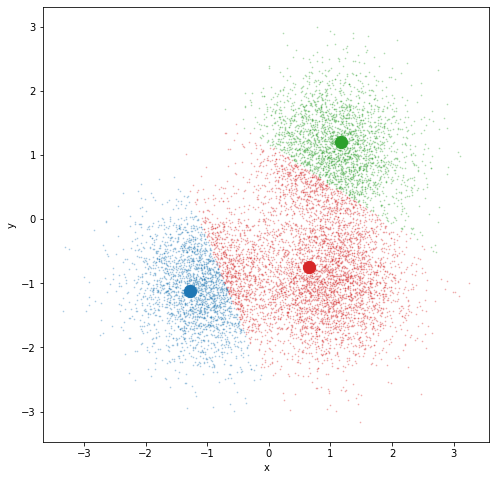

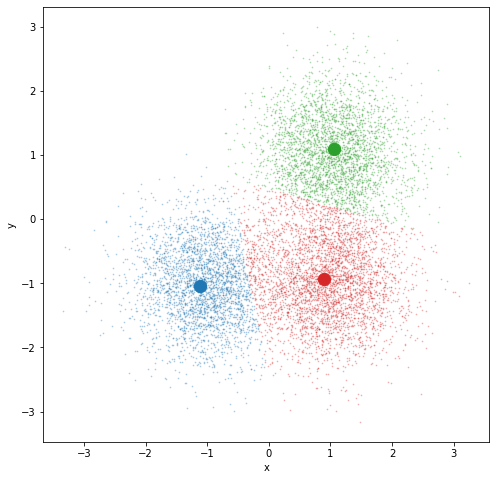

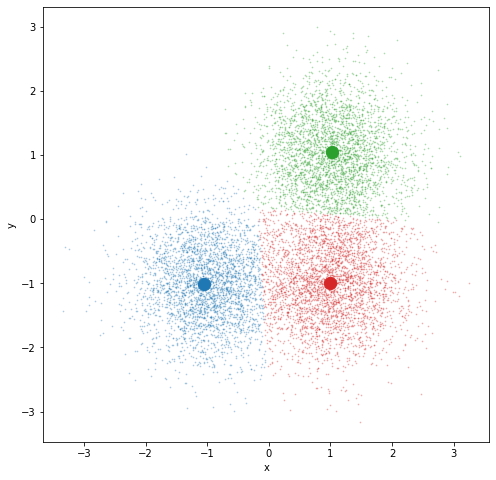

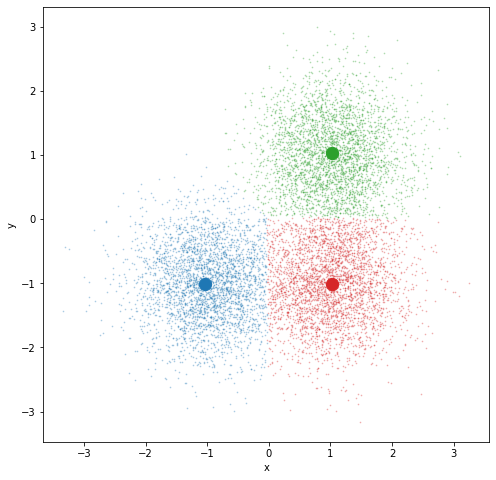

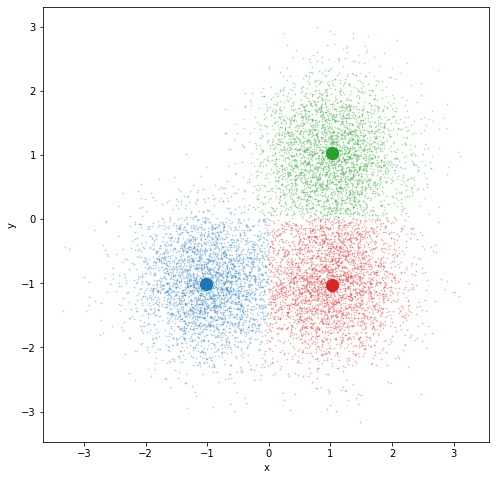

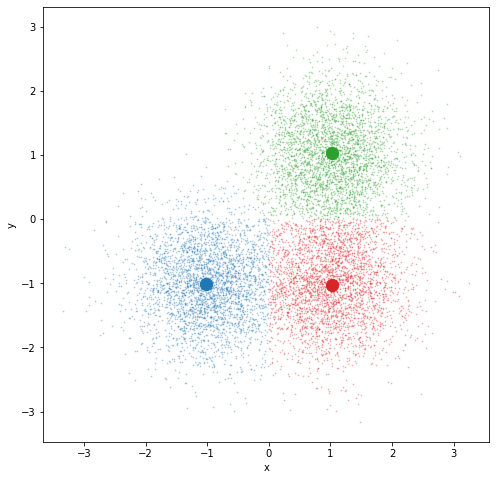

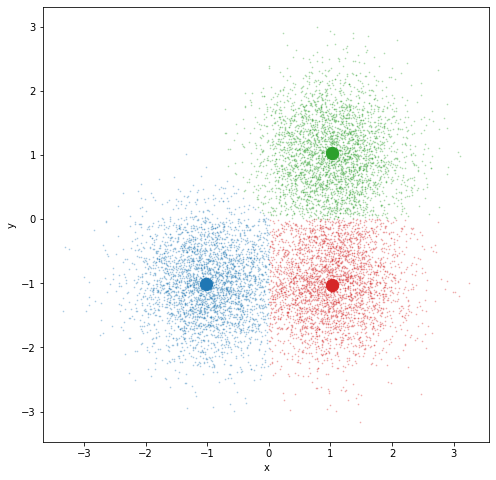

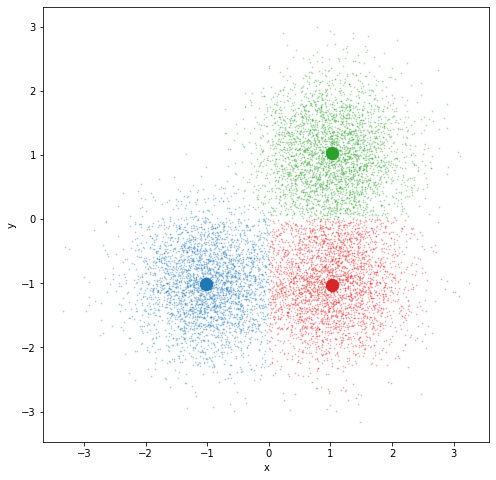

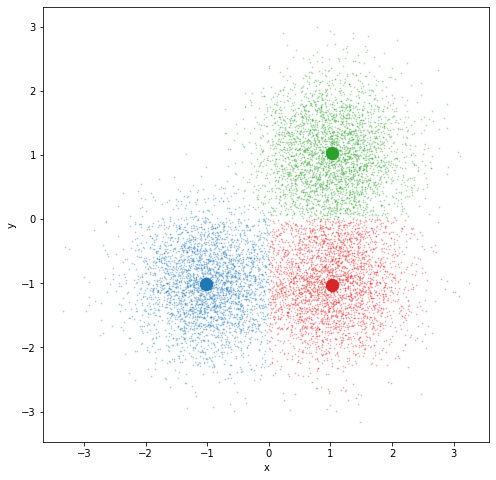

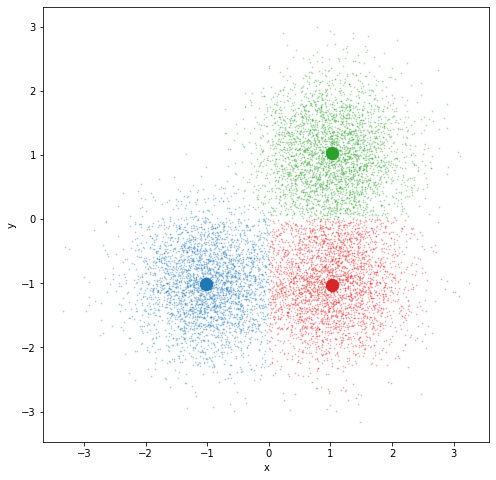

In [ ]:
average_changes = []
for _ in range(10):
  X, centers, center_dist = one_step(X, centers)
  average_changes.append(np.mean(center_dist))

Let's view the change after every iteration.

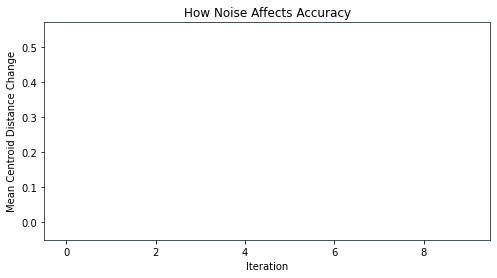

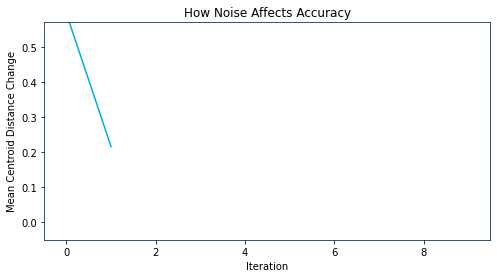

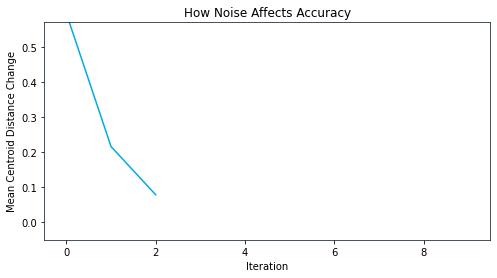

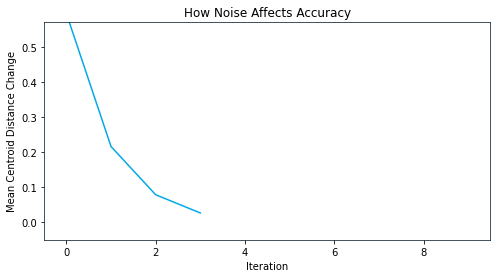

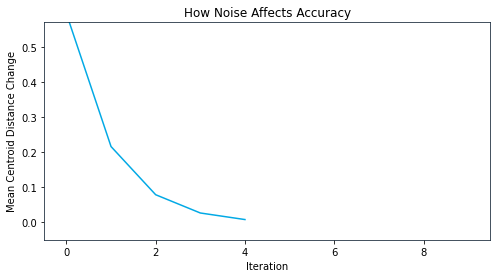

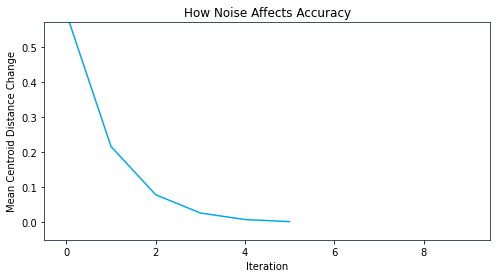

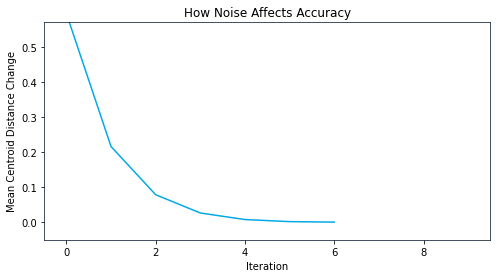

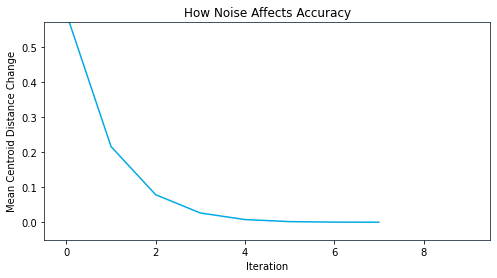

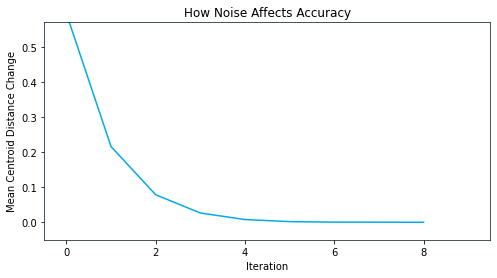

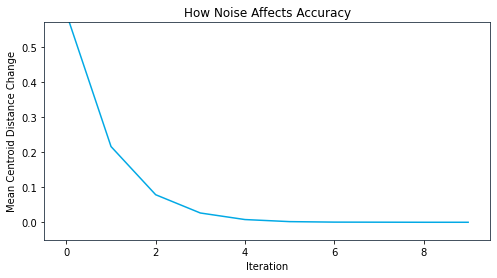

In [ ]:
for i in range(len(average_changes)):

  fig = plt.figure(figsize = (8, 4))
  ax  = fig.add_subplot(1, 1, 1)
  plt.plot(range(len(average_changes[:i+1])), average_changes[:i+1], color = '#02A9E5')
  ax.spines['bottom'].set_color('#18293A')
  ax.spines['top'].set_color('#18293A') 
  ax.spines['right'].set_color('#18293A')
  ax.spines['left'].set_color('#18293A')
  ax.title.set_text('How Noise Affects Accuracy')
  # ax.tick_params(axis = 'x', labelrotation = 45)
  ax.set_ylabel('Mean Centroid Distance Change')
  ax.set_xlabel('Iteration')
  ax.set_ylim((-0.05, 0.57))
  ax.set_xlim((-0.5, 9.5))
  plt.show()  

This method isn't very fast or particularly generalisable to many more clusters because of my specific colour scheme but if you used a matplotlib colour map, this would work for however many clusters. 

This was simply to demonstrate how the method works step by step.